# Chord plots of cell cats and types

## Functions and constants

In [1]:

# Install only missing packages needed elsewhere in the notebook
options(repos = "https://cloud.r-project.org")
pkgs <- c("ggraph", "igraph", "tidyverse", "geomtextpath", "RColorBrewer", "gridExtra")
missing <- pkgs[!pkgs %in% rownames(installed.packages())]
if (length(missing)) {
    install.packages(missing)
}

In [2]:
# Libraries
library(ggraph)
library(igraph)
library(tidyverse)
library(RColorBrewer)
library(geomtextpath)
library(jsonlite)
library(ggforce)


Loading required package: ggplot2


Attaching package: ‘igraph’



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%--%()      masks igraph::%--%()


In [3]:
# Install reticulate for Python interop (to read pickle files)
if (!require("reticulate")) {
  install.packages("reticulate")
}
Sys.setenv(RETICULATE_PYTHON = "/usr/local/bin/python") 
setwd("/root/host_home/sc-luca-explore")
library(reticulate)
py_config() 

Loading required package: reticulate



python:         /usr/local/bin/python
libpython:      /usr/local/lib/libpython3.11.so
pythonhome:     /usr/local:/usr/local
version:        3.11.13 (main, Sep  8 2025, 22:51:55) [GCC 14.2.0]
numpy:          /usr/local/lib/python3.11/site-packages/numpy
numpy_version:  1.26.4

NOTE: Python version was forced by RETICULATE_PYTHON

In [3]:
# Load shared dictionaries from metadata JSON to keep a single source of truth
# Using JSON directly avoids bringing Python objects into R unnecessarily
metadata_path <- file.path("metadata", "cell_mappings.json")
if (!file.exists(metadata_path)) {
    stop(sprintf("Metadata file not found: %s", metadata_path))
}
metadata <- jsonlite::fromJSON(metadata_path)
samples_therapy <- unlist(metadata$samples_therapy)
color_map <- unlist(metadata$color_map)
cell_categories <- metadata$cell_categories
cell_type_to_category <- unlist(lapply(names(cell_categories), function(cat) {
    setNames(rep(cat, length(cell_categories[[cat]])), cell_categories[[cat]])
}))
## Ensure any nodes starting with 'tumor' or 'Tumor' are categorized as 'tumoral' regardless of metadata listing
if (!"tumoral" %in% names(color_map)) {
    warning("'tumoral' category is missing from color_map; adding placeholder color #808080.")
    color_map["tumoral"] <- "#808080"
}
assign_tumoral <- function(mapping) {
    tumor_like <- grepl("^(tumor|Tumor)", names(mapping))
    mapping[tumor_like] <- "tumoral"
    mapping
}
cell_type_to_category <- assign_tumoral(cell_type_to_category)

## Category-Level Circos Plots with Multi-Format Support

The following functions enable creating circos plots at the **category level** (aggregating individual cell types into their categories) with support for both `.txt` network files and `.pkl` graph files.

### Key Functions:

1. **`load_graph_from_file(file_path)`** - Loads graphs from either `.txt` or `.pkl` formats
2. **`plot_category_circos_v2(graph_path, ...)`** - Creates a single circos plot from any graph file
3. **`plot_all_clusters_for_stage(stage, ...)`** - Automatically finds and plots all clusters for a given stage (e.g., "I-II", "III-IV")
4. **`create_multi_cluster_panel(stage, ...)`** - Creates a multi-panel figure showing all clusters in one image

### Features:

- **Chord width scales with connection count** - Thicker chords = more connections between categories
- **Color-coded by category** - Uses consistent color scheme across all plots
- **Automatic file detection** - Finds all cluster files matching a stage pattern
- **Flexible input formats** - Works with both `.txt` network files and `.pkl` NetworkX graph files
- **Batch processing** - Can process and visualize multiple clusters at once

### Example File Paths:
- Single cluster: `"nb_graphAnalysis/output/G_I-II_0.pkl"`
- Pattern matching: `"G_I-II_*.pkl"` will match clusters 0, 1, 2, 3, 4...

### Functions 

In [4]:
# Helper function to load graph from either .txt or .pkl file
load_graph_from_file <- function(file_path) {
  if (grepl("\\.pkl$", file_path)) {
    # Load from pickle file using Python
    tryCatch({
      # Use Python to load the pickle file
      py_run_string("import pickle")
      py_run_string("import networkx as nx")
      py_run_string(sprintf("with open('%s', 'rb') as f: G = pickle.load(f)", file_path))
      
      # Convert NetworkX graph to igraph via edge list
      nx_graph <- py$G
      
      # Get edge list from NetworkX graph
      edge_data <- py_eval("[(u, v, d.get('weight', 1)) for u, v, d in G.edges(data=True)]")
      
      # Create data frame from edges
      edges_df <- data.frame(
        from = sapply(edge_data, function(x) x[[1]]),
        to = sapply(edge_data, function(x) x[[2]]),
        weight = sapply(edge_data, function(x) x[[3]]),
        stringsAsFactors = FALSE
      )
      
      # Get node attributes if they exist
      node_names <- py_eval("list(G.nodes())")
      
      # Create igraph object
      G <- graph_from_data_frame(edges_df, directed = FALSE, vertices = data.frame(name = node_names))
      
      return(G)
    }, error = function(e) {
      stop(paste("Error loading pickle file:", e$message))
    })
  } else if (grepl("\\.txt$", file_path)) {
    # Load from text file
    net <- read.csv(file_path, sep = '\t', col.names = c('from', 'to', 'MI', 'pval'))
    G <- igraph::graph_from_data_frame(net, directed = FALSE)
    return(G)
  } else {
    stop("File must be either .pkl or .txt format")
  }
}

In [63]:
# Updated function to create a circos plot between cell categories
# Now supports both .txt network files and .pkl graph files
# Chord widths vary with the number of connections between categories
plot_category_circos_v2 <- function(graph_path, cell_type_to_category, color_map, 
                                    include_intra = TRUE, title_suffix = "", save_plot = F) {
  
  # Load graph from file (supports both .txt and .pkl)
  G <- load_graph_from_file(graph_path)
  
  # Extract stage/time information from filename
  filename <- basename(graph_path)
  time_info <- gsub(".*_(I{1,3}-I{0,3}V?).*", "\\1", filename)
  cluster_info <- gsub(".*_(\\d+)\\.pkl$", "\\1", filename)
  
  if (grepl("\\.pkl$", graph_path)) {
    plot_title <- paste("Cluster", cluster_info, "- Stages", time_info)
  } else {
    plot_title <- paste("Stages", time_info)
  }
  
  # Assign categories to each node
  node_categories <- cell_type_to_category[V(G)$name]
  missing_idx <- which(is.na(node_categories) & grepl("^(tumor|Tumor)", V(G)$name))
  if (length(missing_idx)) {
    node_categories[missing_idx] <- "tumoral"
  }
  if (anyNA(node_categories)) {
    missing_nodes <- V(G)$name[is.na(node_categories)]
    warning(sprintf("Dropping %d nodes lacking category mapping: %s",
                    length(missing_nodes), paste(head(missing_nodes, 10), collapse = ", ")))
    keep_vertices <- which(!is.na(node_categories))
    if (!length(keep_vertices)) {
      stop("No nodes with valid category mapping remain after filtering.")
    }
    G <- induced_subgraph(G, vids = keep_vertices)
    node_categories <- node_categories[keep_vertices]
  }
  V(G)$category <- node_categories
  
  # Count connections between categories
  edge_list <- as_edgelist(G)
  if (!nrow(edge_list)) {
    stop("Graph has no edges after filtering; cannot create circos plot.")
  }
  edge_categories <- data.frame(
    from_cat = cell_type_to_category[edge_list[,1]],
    to_cat = cell_type_to_category[edge_list[,2]],
    stringsAsFactors = FALSE
  )
  # Treat tumor-prefixed nodes as tumoral when missing
  edge_categories$from_cat[is.na(edge_categories$from_cat) & grepl("^(tumor|Tumor)", edge_list[,1])] <- "tumoral"
  edge_categories$to_cat[is.na(edge_categories$to_cat) & grepl("^(tumor|Tumor)", edge_list[,2])] <- "tumoral"
  
  edge_categories <- edge_categories %>%
    dplyr::filter(!is.na(from_cat) & !is.na(to_cat))
  
  if (!nrow(edge_categories)) {
    stop("No edges with valid category mappings; check metadata definitions.")
  }
  
  # Aggregate connections between categories
  # Ensure consistent ordering (alphabetical) to avoid double counting
  edge_categories$cat1 <- pmin(edge_categories$from_cat, edge_categories$to_cat)
  edge_categories$cat2 <- pmax(edge_categories$from_cat, edge_categories$to_cat)
  
  # Count connections between category pairs
  category_connections <- edge_categories %>%
    group_by(cat1, cat2) %>%
    summarise(weight = n(), .groups = 'drop')
  
  # Separate inter-category and intra-category connections
  inter_connections <- category_connections %>%
    filter(cat1 != cat2)
  
  intra_connections <- category_connections %>%
    filter(cat1 == cat2)
  
  # Create the connection dataframe for circos plot
  if (include_intra) {
    connections_df <- category_connections
  } else {
    connections_df <- inter_connections
  }
  
  if (!nrow(connections_df)) {
    stop("No connections available to plot after applying filters.")
  }
  
  # Get all unique categories
  all_categories <- sort(unique(c(connections_df$cat1, connections_df$cat2)))
  
  # Ensure we have colors for every category
  missing_colors <- setdiff(all_categories, names(color_map))
  if (length(missing_colors)) {
    warning(sprintf("Assigning fallback colors to %d missing categories: %s",
                    length(missing_colors), paste(missing_colors, collapse = ", ")))
    fallback_cols <- grDevices::rainbow(length(missing_colors))
    names(fallback_cols) <- missing_colors
    color_map <- c(color_map, fallback_cols)
  }
  
  # Create graph from category connections
  vertices_df <- data.frame(
    name = all_categories,
    color = color_map[all_categories],
    stringsAsFactors = FALSE
  )
  cat_graph <- graph_from_data_frame(connections_df, directed = FALSE, vertices = vertices_df)
  
  # Attach self-connection weights to vertices for later aesthetics
  self_weights <- setNames(rep(0, length(all_categories)), all_categories)
  if (nrow(intra_connections)) {
    self_weights[intra_connections$cat1] <- intra_connections$weight
  }
  V(cat_graph)$self_weight <- self_weights[V(cat_graph)$name]
  V(cat_graph)$label <- paste0(V(cat_graph)$name, " (", V(cat_graph)$self_weight, ")")
  
  # Set edge weights
  E(cat_graph)$weight <- connections_df$weight
  
  # Create circular layout
  layout <- create_layout(cat_graph, layout = 'linear', circular = TRUE) %>%
    mutate(
      self_weight = tidyr::replace_na(self_weight, 0),
      label = paste0(name, " (", self_weight, ")")
    )
  
  # Determine arc geometry for nodes
  node_count <- nrow(layout)
  angle_seq <- seq(0, 2 * pi, length.out = node_count + 1)
  layout <- layout %>%
    arrange(.ggraph.index) %>%
    mutate(
      angle_start = angle_seq[1:node_count],
      angle_end = angle_seq[2:(node_count + 1)],
      arc_r0 = 1.0
    )
  max_self <- max(layout$self_weight, na.rm = TRUE)
  layout <- layout %>%
    mutate(
      arc_r = if (max_self > 0) arc_r0 + + 0.1 + log2(1+self_weight)*0.05 else arc_r0 + 0.1
    )
  
  # Compute label geometry so text follows the arc at its midpoint
  layout <- layout %>%
    mutate(
      mid_angle = (angle_start + angle_end) / 2,
      mid_angle = (angle_start ),
      label_radius = arc_r + 0.03,
      label_x = label_radius * sin(mid_angle),
      label_y = label_radius * cos(mid_angle),
      angle_raw = - mid_angle * 180 / pi,
      angle_wrapped = ((angle_raw + 180) %% 360) - 180,
      flip_text = angle_wrapped > 90 | angle_wrapped < -90,
      label_angle = ifelse(flip_text, angle_wrapped + 180, angle_wrapped),
      label_angle = ifelse(label_angle > 180, label_angle - 360, label_angle),
      label_angle = ifelse(label_angle < -180, label_angle + 360, label_angle),
      label_hjust = ifelse(flip_text, 1, 0)
    ) %>%
    arrange(.ggraph.index)
  
  # Create the circos plot
  p <- ggraph(layout) +
    # Draw node arcs sized by self-connections
    geom_arc_bar(
      data = layout,
      aes(
        x0 = 0, y0 = 0,
        r0 = arc_r0, r = arc_r,
        start = angle_start, end = angle_end,
        fill = color
      ),
      color = NA, alpha = 0.85
    ) +
    scale_fill_identity() +
    # Draw edges (chords) with width proportional to connection count
    geom_edge_arc(aes(width = weight, color = node1.color, alpha = 0.6), 
                  strength = 0.5) +
    scale_edge_width(range = c(0.5, 5), name = "# Connections") +
    scale_edge_color_identity() +
    scale_edge_alpha_identity() +
    # Add labels positioned along the arc midpoint
    geom_text(
      data = layout,
      aes(x = label_x, y = label_y, label = label, angle = label_angle, hjust = label_hjust),
      color = "black", size = 4, fontface = "bold"
    ) +
    scale_color_identity() +
    # Theme
    theme_void() +
    theme(
      legend.position = "right",
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
      legend.text = element_text(size = 10)
    ) +
    ggtitle(paste("Cell Category Co-abundance Network -", plot_title, title_suffix)) +
    expand_limits(x = c(-1.8, 1.8), y = c(-1.8, 1.8))
  
  # Save the plot
  output_name <- gsub("\\.(txt|pkl)$", "_category_circos.png", filename)
  output_path <- file.path(dirname(graph_path), output_name)
  if(save_plot){
    ggsave(filename = output_path, plot = p, dpi = 400, width = 12, height = 10)
    cat("Plot saved to:", output_path, "\n")
  }
  cat("Number of category pairs:", nrow(connections_df), "\n")
  cat("Total connections:", sum(connections_df$weight), "\n\n")
  
  return(p)
}

In [6]:
# Function to plot all clusters for a given cancer stage
# Automatically finds all cluster files matching the stage pattern

plot_all_clusters_for_stage <- function(stage, base_folder = "nb_graphAnalysis/output", 
                                       cell_type_to_category, color_map,
                                       include_intra = TRUE) {
  
  # Find all pickle files for the given stage
  pattern <- paste0("G_", stage, "_\\d+\\.pkl$")
  all_files <- list.files(base_folder, pattern = pattern, full.names = TRUE)
  
  if (length(all_files) == 0) {
    stop(paste("No cluster files found for stage", stage, "in", base_folder))
  }
  
  cat("Found", length(all_files), "cluster files for stage", stage, "\n")
  cat("Files:", paste(basename(all_files), collapse = ", "), "\n\n")
  
  # Create a list to store all plots
  plots_list <- list()
  
  # Loop through each file and create a plot
  for (i in seq_along(all_files)) {
    cat("Processing cluster", i-1, "...\n")
    
    tryCatch({
      p <- plot_category_circos_v2(
        graph_path = all_files[i],
        cell_type_to_category = cell_type_to_category,
        color_map = color_map,
        include_intra = include_intra,
        title_suffix = ""
      )
      plots_list[[i]] <- p
    }, error = function(e) {
      cat("Error processing", basename(all_files[i]), ":", e$message, "\n")
    })
  }
  
  cat("\n===== SUMMARY =====\n")
  cat("Successfully created", length(plots_list), "plots for stage", stage, "\n")
  cat("Plots saved in:", base_folder, "\n")
  
  return(plots_list)
}

In [7]:
create_multi_cluster_panel <- function(stage, base_folder = "nb_graphAnalysis/output",
                                      cell_type_to_category, color_map,
                                      ncol = 3, include_intra = TRUE) {
  
  # Find all pickle files for the given stage
  pattern <- paste0("G_", stage, "_\\d+\\.pkl$")
  all_files <- list.files(base_folder, pattern = pattern, full.names = TRUE)
  
  if (length(all_files) == 0) {
    stop(paste("No cluster files found for stage", stage))
  }
  
  # Calculate grid dimensions
  n_plots <- length(all_files)
  nrow_calc <- ceiling(n_plots / ncol)
  
  cat("Creating panel with", n_plots, "clusters in", nrow_calc, "x", ncol, "grid\n")
  
  # Create all plots
  plot_list <- lapply(all_files, function(file_path) {
    plot_category_circos_v2(
      graph_path = file_path,
      cell_type_to_category = cell_type_to_category,
      color_map = color_map,
      include_intra = include_intra
    )
  })
  
  # Arrange in grid
  combined_plot <- do.call(grid.arrange, c(plot_list, ncol = ncol))
  
  # Save the combined plot
  output_file <- file.path(base_folder, paste0("all_clusters_", stage, "_circos.png"))
  ggsave(filename = output_file, plot = combined_plot, 
         dpi = 300, width = ncol * 6, height = nrow_calc * 6)
  
  cat("Combined plot saved to:", output_file, "\n")
  
  return(combined_plot)
}

### Plots

Number of category pairs: 18 
Total connections: 111 



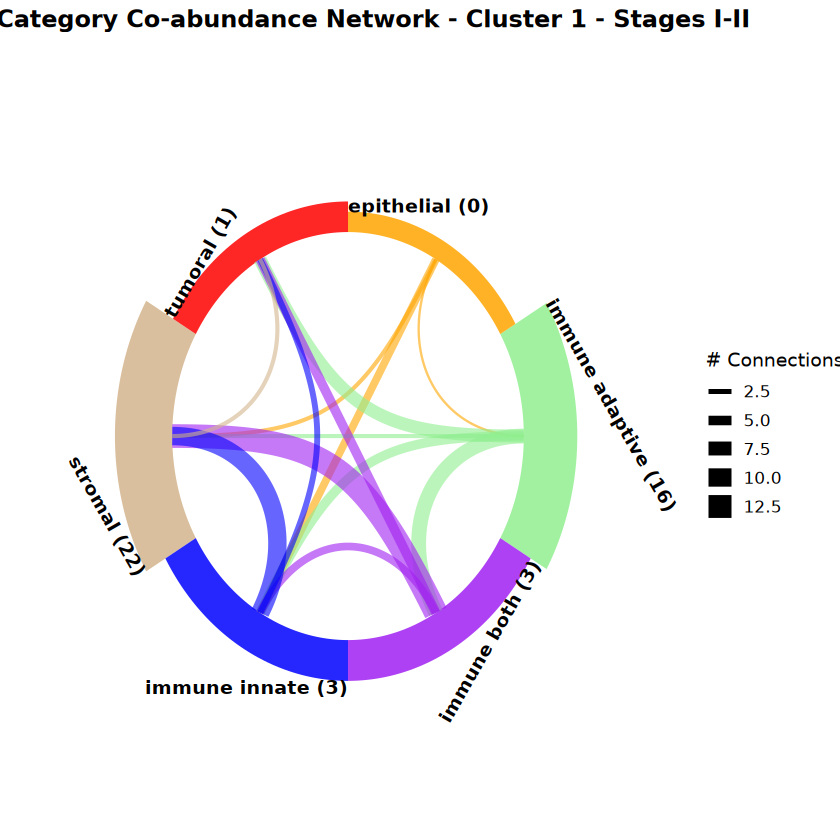

In [64]:
# Example 1: Plot a single cluster from a pickle file
plot_category_circos_v2(
  graph_path = "nb_graphAnalysis/output/G_I-II_1.pkl",
  cell_type_to_category = cell_type_to_category,
  color_map = color_map,
  include_intra = TRUE
)

In [65]:
# Example 3: Plot ALL clusters for Stage III-IV
plots_late <- plot_all_clusters_for_stage(
  stage = "III-IV",
  base_folder = "nb_graphAnalysis/output",
  cell_type_to_category = cell_type_to_category,
  color_map = color_map,
  include_intra = TRUE
)

Found 6 cluster files for stage III-IV 
Files: G_III-IV_0.pkl, G_III-IV_1.pkl, G_III-IV_2.pkl, G_III-IV_3.pkl, G_III-IV_4.pkl, G_III-IV_5.pkl 

Processing cluster 0 ...
Number of category pairs: 18 
Total connections: 131 

Processing cluster 1 ...
Number of category pairs: 18 
Total connections: 97 

Processing cluster 2 ...
Number of category pairs: 17 
Total connections: 85 

Processing cluster 3 ...
Number of category pairs: 17 
Total connections: 80 

Processing cluster 4 ...
Number of category pairs: 16 
Total connections: 86 

Processing cluster 5 ...
Number of category pairs: 17 
Total connections: 133 


===== SUMMARY =====
Successfully created 6 plots for stage III-IV 
Plots saved in: nb_graphAnalysis/output 


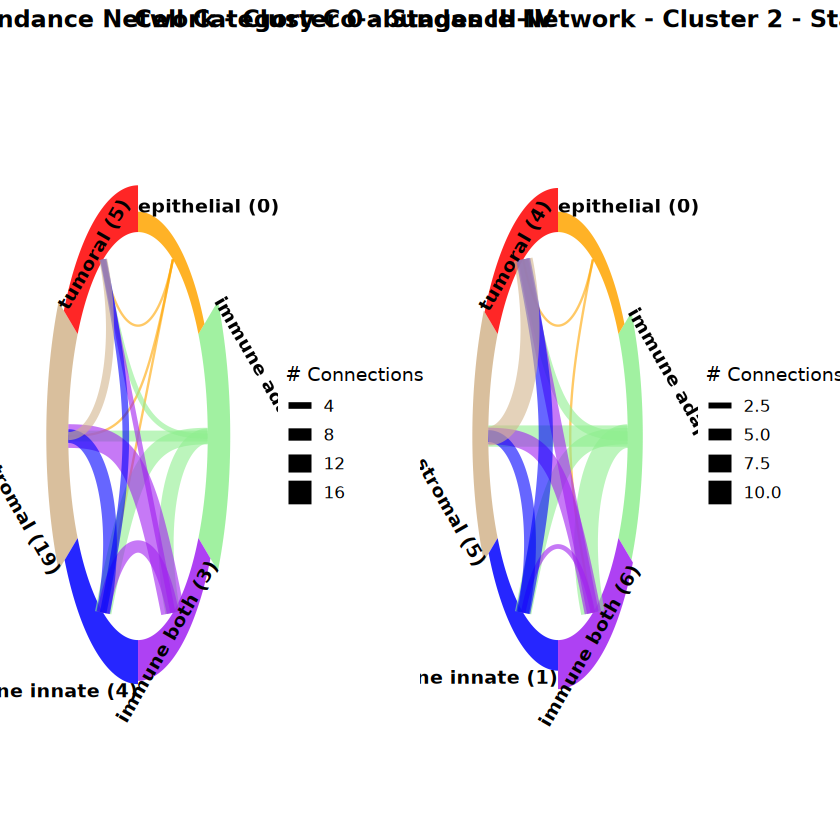

In [66]:
# Example 4: Display specific plots side by side (if you want to compare)
# You can access individual plots from the lists created above
# For example, to show cluster 0 plots from both stages:

library(gridExtra)  # For arranging multiple plots

# Compare cluster 0 from both stages
if (length(plots_late) > 0) {
  grid.arrange(plots_late[[1]], plots_late[[3]], ncol = 2)
}

Creating panel with 6 clusters in 2 x 3 grid
Number of category pairs: 18 
Total connections: 131 

Number of category pairs: 18 
Total connections: 97 

Number of category pairs: 17 
Total connections: 85 

Number of category pairs: 17 
Total connections: 80 

Number of category pairs: 16 
Total connections: 86 

Number of category pairs: 17 
Total connections: 133 

Combined plot saved to: nb_graphAnalysis/output/all_clusters_III-IV_circos.png 
Combined plot saved to: nb_graphAnalysis/output/all_clusters_III-IV_circos.png 


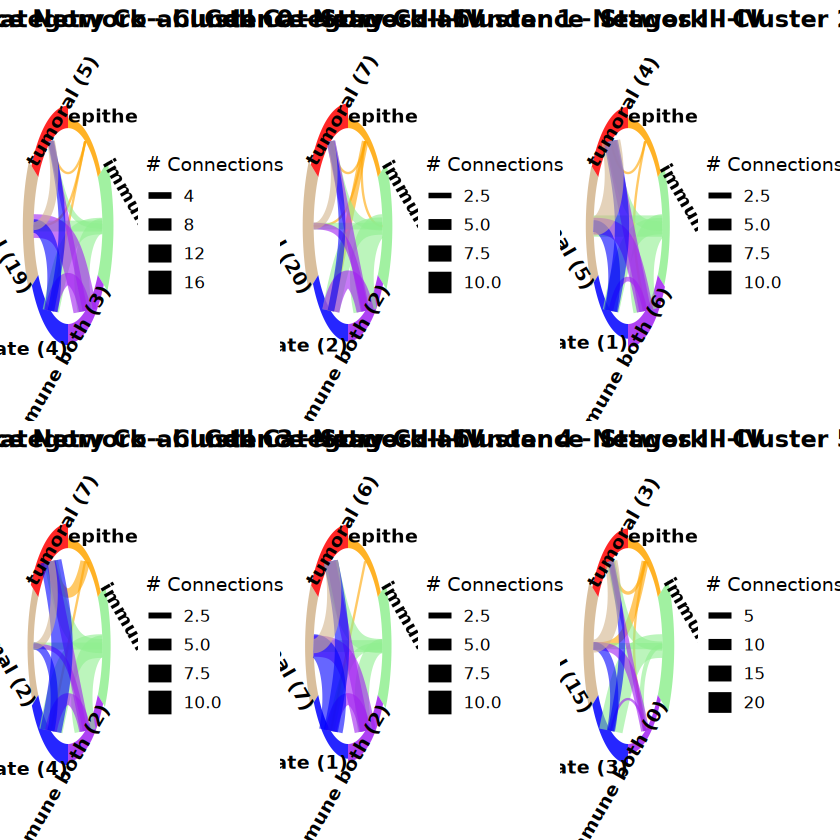

In [67]:
# Example 5: Create a comprehensive comparison plot of all clusters for a stage
# This creates a multi-panel figure showing all clusters at once
library(gridExtra)  # For arranging multiple plots
# Usage: Create multi-panel for Stage I-II
panel_early <- create_multi_cluster_panel(
  stage = "III-IV",
  base_folder = "nb_graphAnalysis/output",
  cell_type_to_category = cell_type_to_category,
  color_map = color_map,
  ncol = 3
)

##  Cell Circos

In [ ]:
plot_circos <- function(time, net_folder, cell_type_to_category, color_map) {
  
  net = read.csv(paste0(net_folder,'/', 'net', time, '.txt'), sep = '\t', col.names = c('from', 'to', 'MI', 'pval'))

  # Extract igraph from net
  G <- igraph::graph_from_data_frame(net, directed = FALSE)



  vertex_df <- as.data.frame(vertex_attr(G))
  vertex_df$order <- 1:vcount(G)  # Preserve the original order

  # Assign cell types and colors
  vertex_df$category <- cell_type_to_category[vertex_df$name]
  vertex_df$color <- color_map[vertex_df$category]

  # Update the graph with the new attributes
  V(G)$category <- vertex_df$category
  V(G)$color <- vertex_df$color

  # Order vertices by group
  vertex_df <- vertex_df[order(vertex_df$color, vertex_df$order), ]
  # Reorder the graph vertices
  G <- permute(G, match(V(G)$name, vertex_df$name))

  # Subset the graph to only include nodes with a certain category
  # category_to_include <- 'tumoral'
  # G <- induced_subgraph(G, V(G)$category == category_to_include)

  # Create the layout with nodes in ordered positions
  layout <- create_layout(G, layout = 'linear', circular = TRUE)

  # Calculate the angle and horizontal adjustment for labels
  layout <- layout %>%
    mutate(angle = 90 - 360 * (1:n()) / n(),
          hjust = ifelse(angle < -90 | angle > 90, 1, 0),
          angle = ifelse(angle < -90 | angle > 90, angle + 180, angle))

  from <- match(as_edgelist(G)[,1], V(G)$name)
  to <- match(as_edgelist(G)[,2], V(G)$name)

  # Create a dataframe from get_con and add a color column
  con_function <- get_con(from = from, to = to)
  # con_df$color <- colorRampPalette(brewer.pal(9, "Set1"))(nrow(con_df))
  con_df <- con_function(layout)

  # Plot the graph
  circos = ggraph(layout) +
    # geom_conn_bundle(data = get_con(from = from, to = to), alpha=0.2, colour="skyblue", width=0.6, tension = 0.9) +
    # geom_conn_bundle(data = con_df, alpha=0.2, aes(colour = con_df$color), width=0.6, tension = 0.9) +
    geom_edge_arc(aes(color = node2.category, alpha = ..index..)) + # very important to observe edge_data <- get_edges()(layout) to see avialable columns
    scale_edge_color_manual(
      values = color_map
    ) +
    # geom_edge_link( aes(colour=after_scale(color))) +
    geom_node_point(aes(colour = category), size = 5) +
    scale_colour_manual(values = color_map) +
    geom_node_text(aes(label = name, angle = angle, hjust = hjust), size = 2, alpha=1.0) +
    guides(colour = guide_legend(override.aes = list(size = 2)), edge_color = "none", edge_alpha = "none") +
    # geom_textpath(data = arc_layout, aes(x = x, y = y, label = "Arc Text Example"), size = 3, color = "red", vjust = -1.15) +
    theme_void() +
    theme(
      legend.position="right",
      legend.margin = margin(0, 0, 0, 15),
      # plot.margin=unit(c(4,1,0,0),"cm"),
      
    ) +
    ggtitle(paste("Cell coabundance for Stages", time)) +
    expand_limits(x = c(-1.5, 1.5), y = c(-1.5, 1.5))

    ggsave(filename = paste0(net_folder,'/circos_plot_', time, '.png'), dpi = 400, width = 10, height = 8)

    return(circos)
}

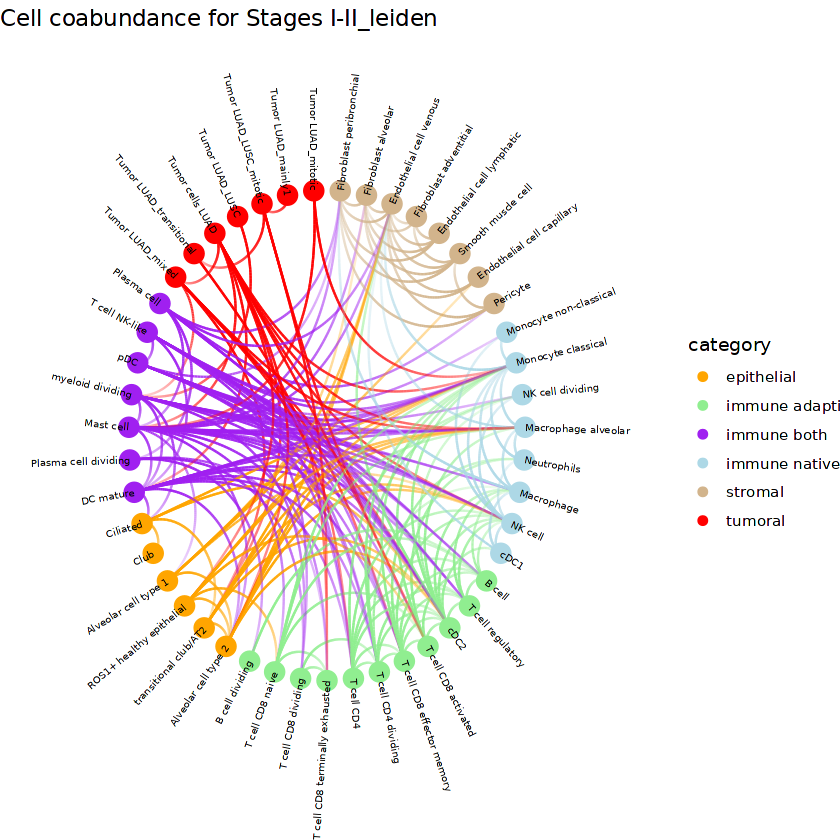

In [ ]:
plot_circos('I-II_leiden', net_folder, cell_type_to_category, color_map)

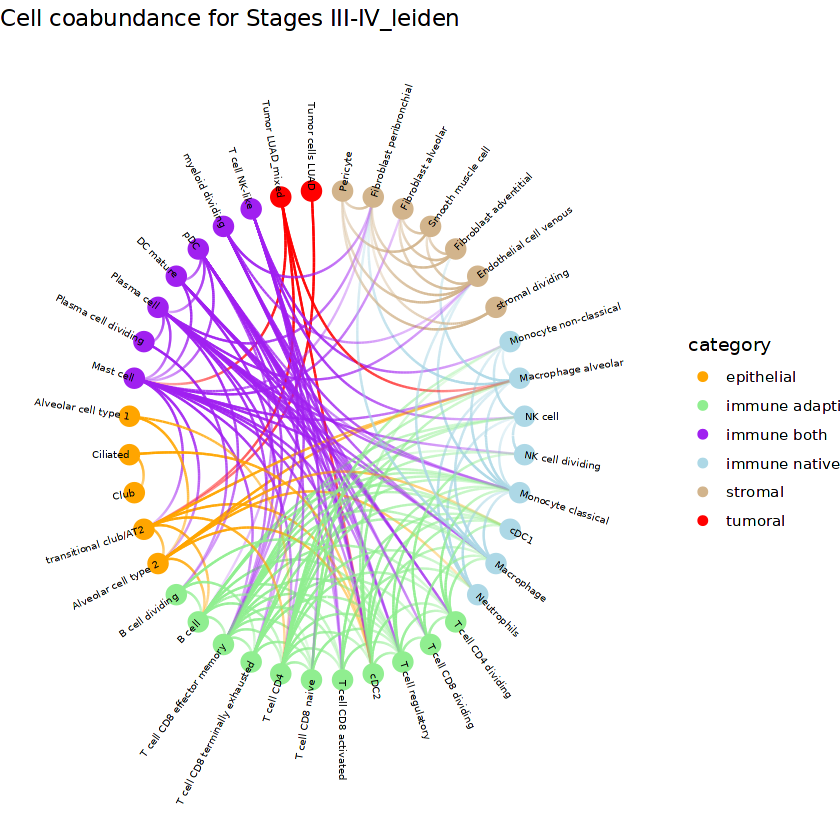

In [171]:
plot_circos('III-IV_leiden', net_folder, cell_type_to_category, color_map)

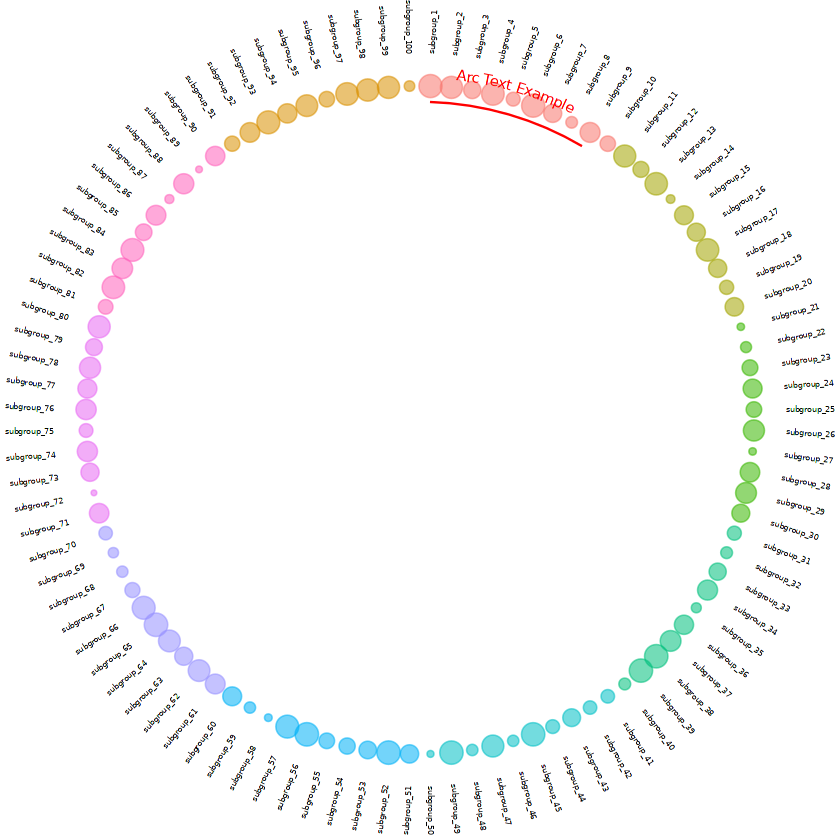

In [ ]:


# Create a graph object
mygraph <- igraph::graph_from_data_frame( edges, vertices=vertices )
 
# The connection object must refer to the ids of the leaves:
from  <-  match( connect$from, vertices$name)
to  <-  match( connect$to, vertices$name)

layout <- create_layout(mygraph, layout = 'dendrogram', circular = TRUE)
arc_layout <- layout[layout$arc == TRUE, ]
# Basic usual argument
ggraph(mygraph, layout = 'dendrogram', circular = TRUE) + 
  geom_node_point(aes(filter = leaf, x = x*1.05, y=y*1.05, colour=group, size=value, alpha=0.2)) +
  geom_conn_bundle(data = get_con(from = from, to = to), alpha=0.2, colour="skyblue", width=0.9) +
  geom_node_text(aes(x = x*1.15, y=y*1.15, filter = leaf, label=name, angle = angle, hjust=hjust), size=1.5, alpha=1) +
  geom_textpath(data = arc_layout, aes(x = x, y = y, label = "Arc Text Example"), size = 3, color = "red", vjust = -1.15) +
  theme_void() +
  theme(
    legend.position="none",
    plot.margin=unit(c(0,0,0,0),"cm"),
  ) +
  expand_limits(x = c(-1.2, 1.2), y = c(-1.2, 1.2))

